In [2]:
import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
import numpy as np
import itertools
import random

In [3]:
X, y = load_whas500()
X = X.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)

In [5]:
X_test.iloc[:1,:]

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
361,0.0,51.0,0.0,40.03658,0.0,1.0,28.0,0.0,86.0,7.0,0.0,1.0,0.0,202.0


In [6]:
print(rsf.decision_path(X_test.iloc[:1,:]))

(<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 728 stored elements and shape (1, 10136)>, array([    0,    97,   192,   287,   388,   481,   580,   687,   794,
         891,  1004,  1101,  1202,  1299,  1396,  1511,  1612,  1703,
        1812,  1909,  2014,  2123,  2228,  2333,  2432,  2539,  2646,
        2751,  2870,  2977,  3078,  3165,  3268,  3363,  3468,  3573,
        3680,  3785,  3894,  3989,  4088,  4199,  4304,  4409,  4512,
        4613,  4718,  4815,  4910,  5025,  5130,  5229,  5340,  5441,
        5554,  5659,  5758,  5853,  5930,  6033,  6128,  6221,  6330,
        6441,  6546,  6649,  6746,  6845,  6950,  7055,  7142,  7247,
        7350,  7459,  7558,  7663,  7760,  7859,  7980,  8083,  8164,
        8257,  8354,  8441,  8546,  8647,  8744,  8853,  8958,  9075,
        9176,  9271,  9372,  9453,  9550,  9655,  9754,  9851,  9944,
       10049, 10136]))


In [7]:
tree_index = 0  # On choisit le premier arbre
tree = rsf.estimators_[tree_index].tree_

In [8]:
tree.value

array([[[0.01      , 0.99      ],
        [0.03777778, 0.9625    ],
        [0.04297258, 0.9575    ],
        ...,
        [1.17368573, 0.25370506],
        [2.17368573, 0.        ],
        [2.17368573, 0.        ]],

       [[0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        ...,
        [1.36309524, 0.125     ],
        [1.36309524, 0.125     ],
        [1.36309524, 0.125     ]],

       [[0.01020408, 0.98979592],
        [0.0385546 , 0.96173469],
        [0.04385964, 0.95663265],
        ...,
        [1.15784971, 0.25777307],
        [2.15784971, 0.        ],
        [2.15784971, 0.        ]],

       ...,

       [[0.        , 1.        ],
        [0.15384615, 0.84615385],
        [0.24475524, 0.76923077],
        ...,
        [1.86142191, 0.        ],
        [1.86142191, 0.        ],
        [1.86142191, 0.        ]],

       [[0.        , 1.        ],
        [0.33333333, 0.66666667],
        [0.58333333, 0.5       ],
        .

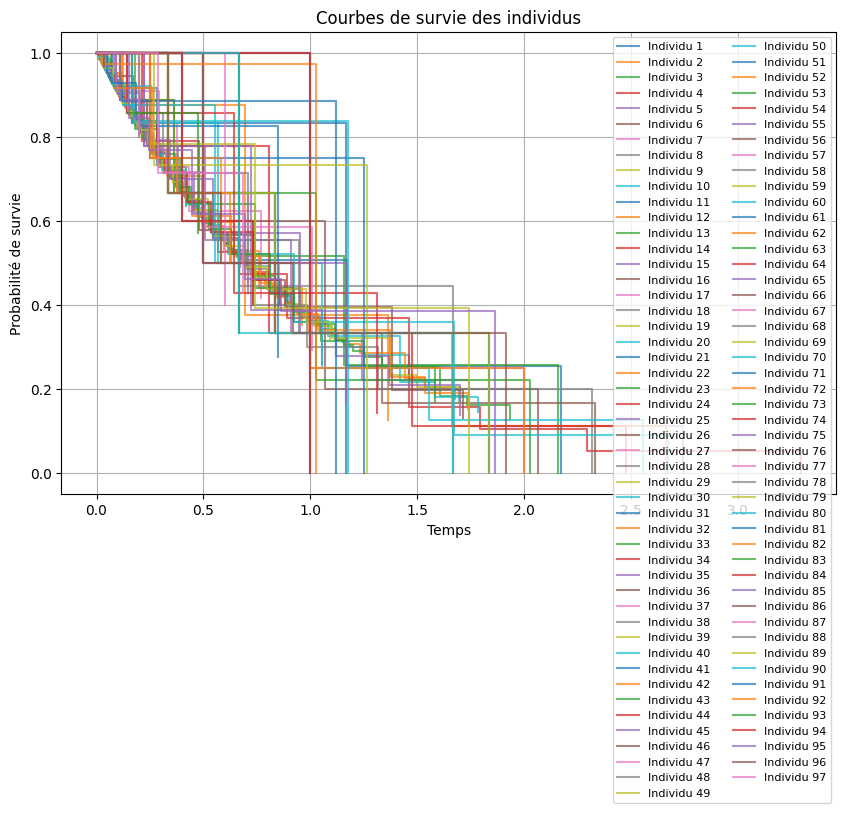

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées (remplace par ton tableau complet)
survival_data = tree.value

# Nombre d'individus (première dimension du tableau)
num_individuals = survival_data.shape[0]

plt.figure(figsize=(10, 6))

# Tracer une courbe pour chaque individu
for i in range(num_individuals):
    times = survival_data[i, :, 0]  # Temps
    survival_probs = survival_data[i, :, 1]  # Probabilité de survie
    plt.step(times, survival_probs, where='post', label=f'Individu {i+1}', alpha=0.7)

# Mise en forme du graphe
plt.xlabel("Temps")
plt.ylabel("Probabilité de survie")
plt.title("Courbes de survie des individus")
plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.ylim(-0.05, 1.05)  # Probabilités entre 0 et 1
plt.grid(True)

# Affichage
plt.show()

In [11]:
for node in range(78,81):
    left_child = tree.children_left[node]
    right_child = tree.children_right[node]
    feature_index = tree.feature[node]
    threshold = tree.threshold[node]
    
    print(f"Nœud {node}:")
    print(f"  Feature utilisée: {X.columns[feature_index] if feature_index != -2 else 'Leaf'}")
    print(f"  Seuil: {threshold:.3f}")
    print(f"  Fils gauche: {left_child}, Fils droit: {right_child}")
    print("-" * 30)

Nœud 78:
  Feature utilisée: sho
  Seuil: 0.500
  Fils gauche: 79, Fils droit: 94
------------------------------
Nœud 79:
  Feature utilisée: age
  Seuil: 80.500
  Fils gauche: 80, Fils droit: 91
------------------------------
Nœud 80:
  Feature utilisée: cvd
  Seuil: 0.500
  Fils gauche: 81, Fils droit: 84
------------------------------


In [12]:
def same_path(X, obs, rsf, tree_index, depth=0):
    #X entrainement, obs a etudier, rsf mdoele, tree index, l'arbre
    nodes=rsf.estimators_[tree_index].decision_path(obs).indices
    X = X.reset_index(drop=True)
    for node in nodes[depth:-1]:
        var=tree.feature[node]
        seuil=tree.threshold[node]
        X = X[X.iloc[:, var] >= seuil] if obs.iloc[0,var]>= seuil else X[X.iloc[:, var] < seuil]
    return X

same_path=same_path(X_train, X_test.iloc[:1,:], rsf, 0)


/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SurvivalTree was fitted without feature names
  warnings.warn(


In [13]:
def surv_est(same_path, y_train, times):
    y_train_list = np.array(y_train.tolist())[same_path.index]
    KMF= KaplanMeierFitter()
    KMF.fit(y_train_list[:, 1],y_train_list[:, 0])
    return(KMF.predict(times))

surv_est(same_path, y_train, list(range(5,100,5)))

5     1.000000
10    1.000000
15    1.000000
20    1.000000
25    1.000000
30    1.000000
35    1.000000
40    1.000000
45    1.000000
50    0.970588
55    0.970588
60    0.970588
65    0.970588
70    0.970588
75    0.970588
80    0.970588
85    0.970588
90    0.970588
95    0.970588
Name: KM_estimate, dtype: float64

In [14]:
def rpermut(n):
    random_permutations = []

    for _ in range(n):
        shuffled = list(X.columns)  # Copier la liste
        random.shuffle(shuffled)  # Mélanger aléatoirement
        random_permutations.append(tuple(shuffled))  # Ajouter en tuple (comme permutations)

    return(random_permutations)

In [ ]:
class parasite:
    def __init__(self, number, left=None, right=None, future_features=None, feature=None, value=None, weight=None, path=None):
        self.number=number
        self.left=left
        self.right=right
        self.future_features=future_features
        self.feature=feature
        self.value=value
        self.weight=weight
        self.path=None
    
    def copy_tree(self, tree):
        if tree.feature[number] == -2:
            return (parasite(number=number, value=))



'age'

In [ ]:
class Arbre:
    def __init__(self, valeur, gauche=None, droite=None):
        """Initialise un arbre avec une valeur et éventuellement deux sous-arbres."""
        self.valeur = valeur
        self.gauche = gauche
        self.droite = droite

    def afficher(self, niveau=0):
        """Affiche l'arbre de manière structurée."""
        if self.droite:
            self.droite.afficher(niveau + 1)
        print("    " * niveau + str(self.valeur))
        if self.gauche:
            self.gauche.afficher(niveau + 1)

# Exemple d'utilisation
arbre = Arbre(10, Arbre(5, Arbre(2), Arbre(7)), Arbre(15, None, Arbre(20)))
arbre.afficher()

        20
    15
10
        7
    5
        2


In [16]:
leaf_indices = rsf.apply(X)
leaf_indices[:,0]

array([53, 87, 82, 87, 87,  1, 87, 89, 65, 14, 83, 90, 14, 27, 19,  8, 25,
       83, 83, 86, 11, 72, 72, 83, 18, 14, 36, 44, 35, 76, 52, 23, 87, 93,
       53, 87, 37, 52, 73, 18, 90, 73, 30,  1, 73, 18, 90, 14, 65, 14, 48,
       11, 55, 44, 95, 86, 17, 17, 52, 87, 60, 86, 90, 93, 90, 95, 48, 82,
       87,  1, 73, 12, 83, 30, 92, 87, 14, 82, 11, 53, 86, 82, 43, 87, 48,
       47, 14, 40, 50, 44, 77, 44, 30, 47, 82, 27, 27, 95, 37, 14, 61, 73,
       28, 73, 93, 83, 11, 44, 19, 14, 83, 69, 93, 87, 56, 12, 73, 83, 11,
       90, 12, 92, 14, 87, 69, 87, 83, 14, 19, 44, 68, 83, 65, 11, 43, 23,
       71, 82, 87, 65, 83, 83, 92, 90, 87, 30, 12, 48, 83, 69, 44, 14, 20,
       87, 30, 28, 61, 95, 44, 96, 30, 14, 37, 43, 96, 25, 14, 14, 90, 93,
       83, 48, 25, 19,  1,  8, 93, 44, 72, 77, 47, 11, 23, 53, 83, 87, 14,
       76, 86, 87, 87, 83, 14, 87, 82, 47,  1, 86, 60, 90, 83, 23, 60, 87,
       14, 44, 40, 83, 47, 35, 60, 87, 83, 40, 50, 65, 87, 43, 44, 83, 52,
       76, 44, 35, 52, 90

In [34]:
rsf.estimators_[0].tree_.value[:,100,1]

array([0.7056751 , 0.125     , 0.7175187 , 0.67957909, 0.87848418,
       0.89315324, 0.95748547, 0.96666667, 0.8       , 0.97647059,
       0.91666667, 1.        , 0.85714286, 0.98630137, 1.        ,
       0.95833333, 0.85714286, 0.66666667, 1.        , 1.        ,
       0.83333333, 0.52941176, 0.63636364, 0.75      , 0.33333333,
       0.33333333, 0.72727273, 0.66666667, 0.8       , 0.52682205,
       0.        , 0.53695324, 0.42553191, 0.10526316, 0.22222222,
       0.        , 0.5       , 0.        , 0.50666667, 0.43076923,
       0.        , 0.4516129 , 0.44      , 1.        , 0.33333333,
       0.45945946, 0.66666667, 0.42857143, 1.        , 0.36      ,
       1.        , 0.11111111, 0.22222222, 0.        , 1.        ,
       1.        , 1.        , 0.70810386, 0.65136476, 0.125     ,
       0.        , 0.25      , 0.7469697 , 0.8384755 , 0.83309958,
       1.        , 0.77101449, 0.55555556, 0.        , 0.83333333,
       0.92857143, 0.75      , 1.        , 0.85714286, 0.16666

In [35]:
rsf.estimators_[0].tree_.weighted_n_node_samples

array([400.,   8., 392., 283., 124., 113.,  96.,  90.,   5.,  85.,  12.,
         5.,   7.,  73.,  49.,  24.,   7.,   3.,   4.,  17.,   6.,  17.,
        11.,   8.,   3.,   6.,  11.,   6.,   5., 159.,   3., 156.,  94.,
        19.,   9.,   5.,   4.,  10.,  75.,  65.,   3.,  62.,  25.,   4.,
        21.,  37.,  12.,   7.,   5.,  25.,   7.,  18.,   9.,   9.,  10.,
         4.,   6.,  62.,  52.,   8.,   4.,   4.,  44.,  38.,  31.,   8.,
        23.,   9.,   3.,   6.,  14.,   4.,  10.,   7.,   6.,  10.,   5.,
         5., 109.,  96.,  84.,  39.,   5.,  34.,  45.,  30.,   5.,  25.,
        15.,   6.,   9.,  12.,   7.,   5.,  13.,   6.,   7.])